## DataLoader and necessary imports

In [1]:
from IPython import display
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd
import time
import torch.optim as optim
import torch.nn.functional as nnF
#%%
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label
#%%
def get_dataloader():
    path='C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/'
    df_train=pd.read_csv(path+'train.csv')
    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    df_val=pd.read_csv(path+'val.csv')
    dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    df_test=pd.read_csv(path+'test.csv')
    dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    return loader_train, loader_val, loader_test

In [2]:
loader_train, loader_val, loader_test = get_dataloader()

In [3]:
loader_train.dataset[0][0].shape

C:\Users\matth\AppData\Local\Temp\ipykernel_40688\156424910.py:29: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


torch.Size([3, 224, 224])

In [4]:
loader_train.dataset[0][1]

C:\Users\matth\AppData\Local\Temp\ipykernel_40688\156424910.py:29: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


tensor(0)

## 10 points: construct a CNN by modifying Resnet-18 for binary classification

In [5]:
import torchvision
from torchvision.models import ResNet18_Weights
class Net(torch.nn.Module):
    def __init__(self, tranfer_learning):
        super().__init__()        
        #use resnet18 as the base model
        if tranfer_learning == True:
            self.resnet18 = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        else:
            self.resnet18 = torchvision.models.resnet18() #random weights
        #modified the last layer for binary classification  
        self.resnet18.fc=torch.nn.Linear(512, 2)           
        
        if tranfer_learning == True:
            #freeze all parameters
            for p in self.resnet18.parameters():
                p.requires_grad = False 
            #set the parameters of layer4 to be trainable       
            for p in self.resnet18.layer4.parameters():
                p.requires_grad = True       
            #set the parameters of fc to be trainable       
            for p in self.resnet18.fc.parameters():
                p.requires_grad = True       
        
    def get_trainable_parameters(self):
        pList=list(self.resnet18.layer4.parameters())+list(self.resnet18.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet18(x)
        return z

In [6]:
#model=Net()

## 25 points: train the CNN from scratch

In [7]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [8]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp=Z.max(dim=-1)[1]
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

In [9]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.cross_entropy(Z, Y)
            loss_test+=loss.item()
            Yp=Z.max(dim=-1)[1]
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)   
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
modelS=Net(tranfer_learning=False)
modelS.to(device)
#optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
#optimizer = optim.SGD(modelS.parameters(), lr=0.0001, momentum=0.99) 
optimizer = optim.Adam(modelS.parameters(), lr=0.0001) 
#---------------------------------------------------------
(x,label)=loader_train.dataset[0]
x=x.view(1,3,224,224).to(device)
z=modelS(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cuda:0


C:\Users\matth\AppData\Local\Temp\ipykernel_40688\156424910.py:29: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


In [11]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [12]:
#update learning reate
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

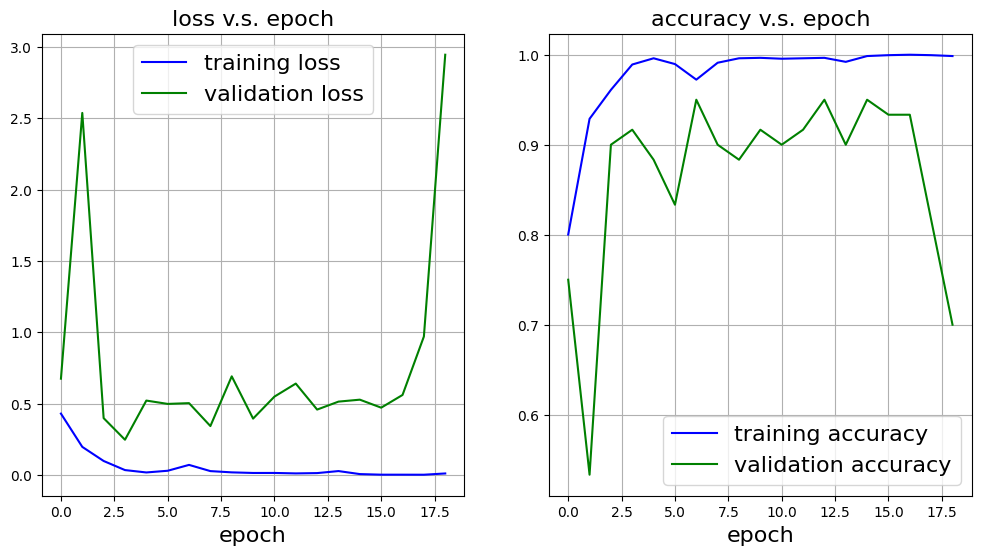

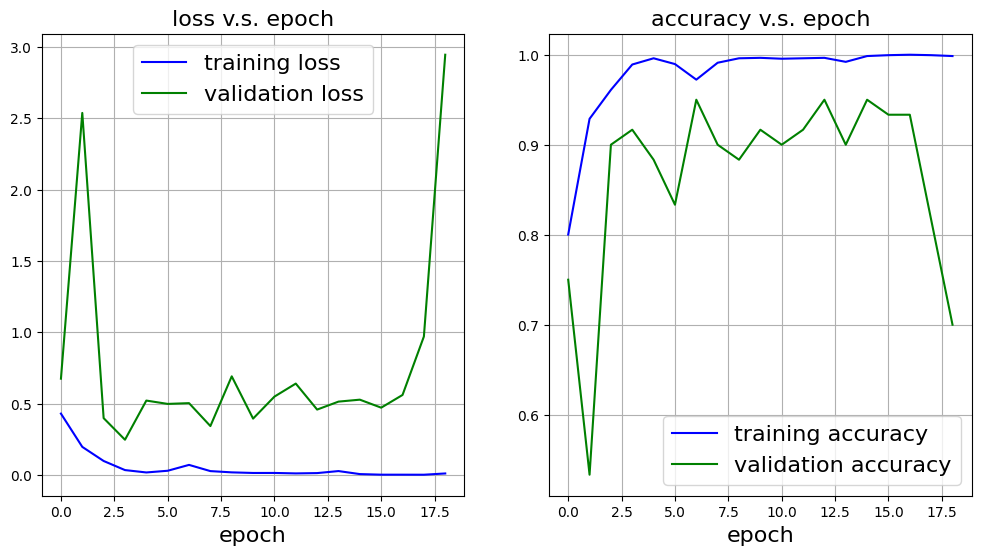

In [13]:
for epoch in range(epoch_save+1, epoch_save+20):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(modelS, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(modelS, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    t1=time.time()
    print("time cost", t1-t0)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('modelS_epoch'+str(epoch)+'.pt', modelS, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

In [14]:
#test
loss_test, acc_test, other_test = test(modelS, device, loader_test)
acc_test

C:\Users\matth\AppData\Local\Temp\ipykernel_40688\156424910.py:29: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


0.6775

## 40 points: visualize the two models (2)&(3) using two CAM methods (e.g., GradCAM and EigenCAM)

In [15]:
!pip install grad-cam

In [16]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import torch
import matplotlib.pyplot as plt
import skimage

In [17]:
#choose the target layer(s)
target_layers = [modelS.resnet18.layer4[-1]]

(224, 224)


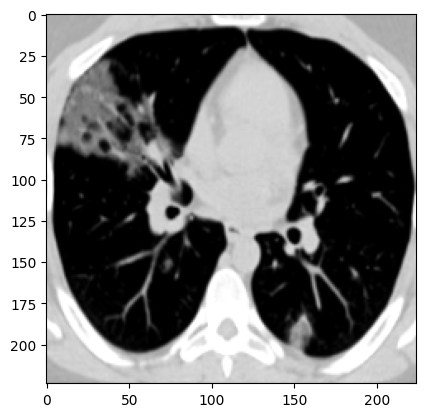

In [18]:
#load a single rgb image from harddrive
image_gray=skimage.io.imread("C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/COVID/Covid (22).png")
image_gray=image_gray.astype("float32")
image_gray=image_gray/image_gray.max()
image_gray.shape
print(image_gray.shape)
plt.imshow(image_gray, cmap='gray')

(224, 224, 3)


torch.Size([1, 3, 224, 224])

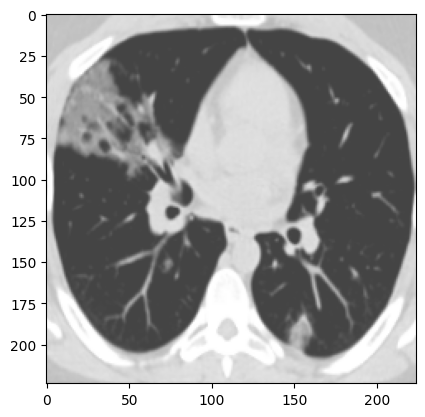

In [19]:
#if the image is gray-scale, then convert it to rgb
#image_gray=np.random.rand(224,224)
#image_gray.shape (224,224)
image_gray=image_gray.reshape(224,224,1)
image_color=np.concatenate([image_gray, image_gray, image_gray], axis=2)
print(image_color.shape)
plt.imshow(image_color)

#convert numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

In [20]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [24]:
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=modelS, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
#category 281 is tabby, tabby cat

targets = [ClassifierOutputTarget(category=1)] # 0 or 1

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam.shape


(1, 224, 224)

(224, 224, 3)


torch.Size([1, 3, 224, 224])

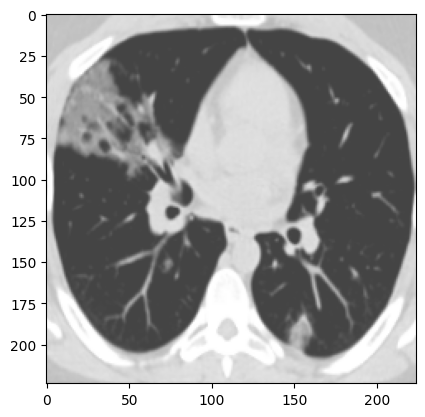

In [25]:
#load a single rgb image from harddrive

image_gray1=skimage.io.imread("C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/COVID/Covid (22).png")
image_gray1=image_gray1.astype("float32")
image_gray1=image_gray1/image_gray1.max()
image_gray1.shape

image_gray1=image_gray1.reshape(224,224,1)
image_color=np.concatenate([image_gray1, image_gray1, image_gray1], axis=2)
print(image_color.shape)
plt.imshow(image_color)

#convert numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

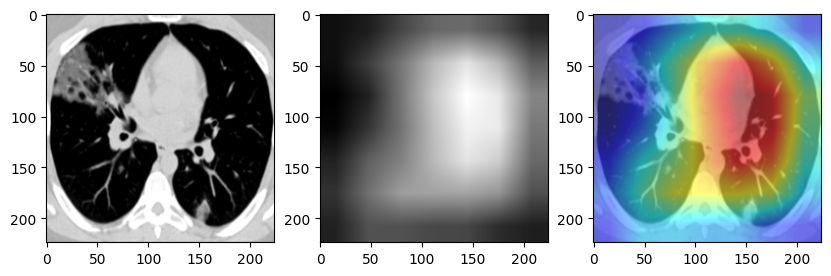

In [30]:
#GradCAM for image_gray1
cam = GradCAM(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray1, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray1, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

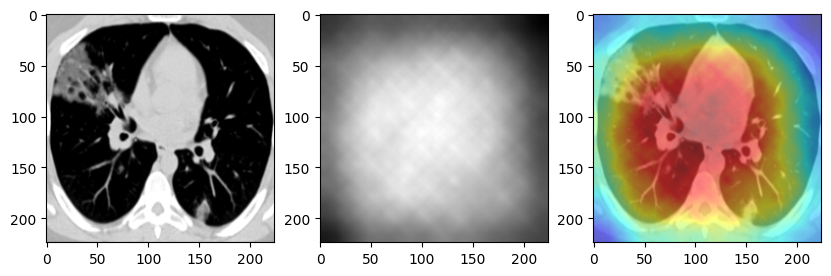

In [31]:
#FullGrad for image_gray1
cam = FullGrad(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray1, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray1, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

(224, 224, 3)


torch.Size([1, 3, 224, 224])

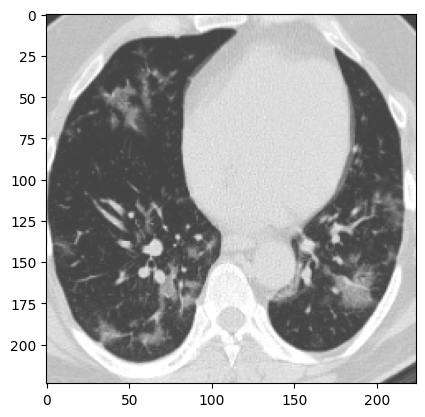

In [32]:
image_gray2=skimage.io.imread("C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/COVID/Covid (282).png")
image_gray2=image_gray2.astype("float32")
image_gray2=image_gray2/image_gray2.max()
image_gray2.shape

image_gray2=image_gray2.reshape(224,224,1)
image_color=np.concatenate([image_gray2, image_gray2, image_gray2], axis=2)
print(image_color.shape)
plt.imshow(image_color)

#convert numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

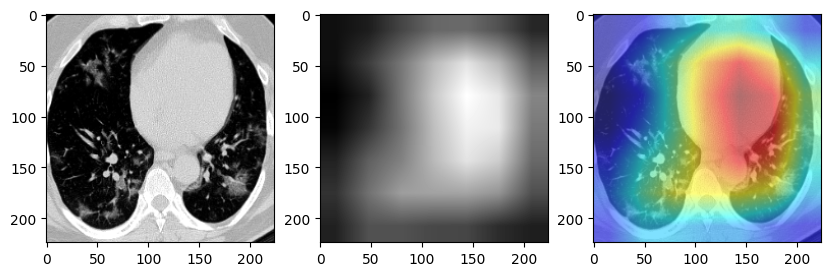

In [34]:
#GradCAM for image_gray2
cam = GradCAM(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray2, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray2, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

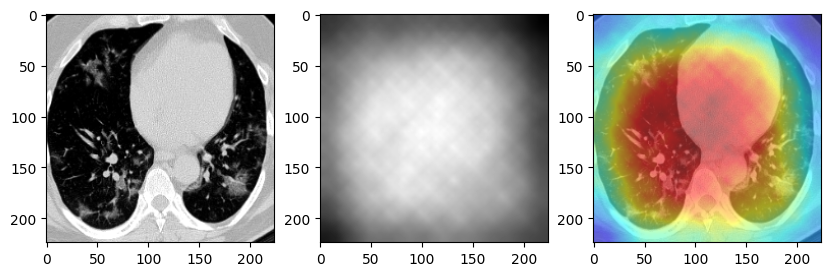

In [35]:
#FullGrad for image_gray2
cam = FullGrad(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray2, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray2, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

(224, 224, 3)


torch.Size([1, 3, 224, 224])

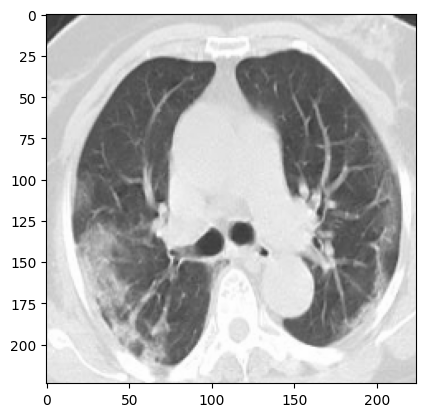

In [36]:
image_gray3=skimage.io.imread("C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/COVID/Covid (493).png")
image_gray3=image_gray3.astype("float32")
image_gray3=image_gray3/image_gray3.max()
image_gray3.shape

image_gray3=image_gray3.reshape(224,224,1)
image_color=np.concatenate([image_gray3, image_gray3, image_gray3], axis=2)
print(image_color.shape)
plt.imshow(image_color)

#convert numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

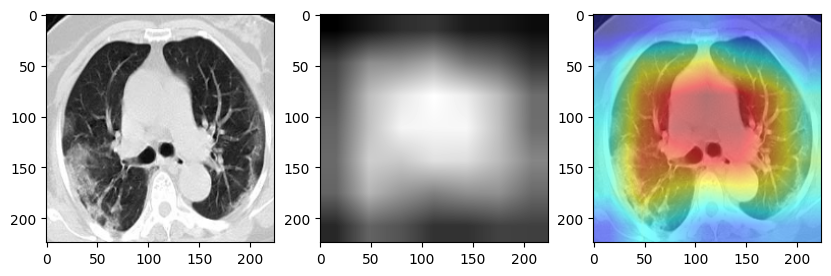

In [37]:
#GradCAM for image_gray3
cam = GradCAM(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray3, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray3, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

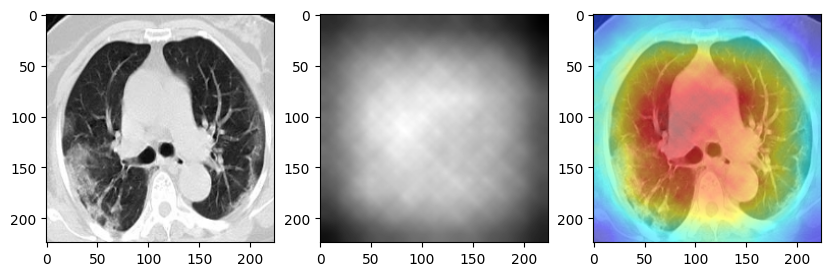

In [38]:
#FullGrad for image_gray3
cam = FullGrad(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray3, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray3, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

(224, 224, 3)


torch.Size([1, 3, 224, 224])

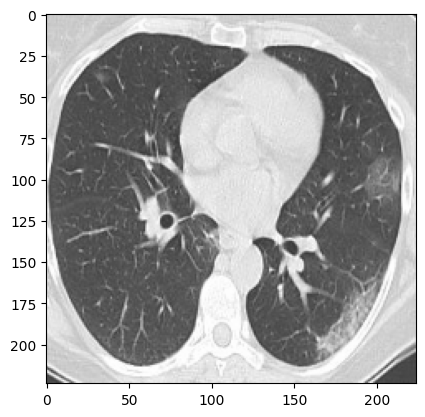

In [39]:
image_gray4=skimage.io.imread("C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/COVID/Covid (841).png")
image_gray4=image_gray4.astype("float32")
image_gray4=image_gray4/image_gray4.max()
image_gray4.shape

image_gray4=image_gray4.reshape(224,224,1)
image_color=np.concatenate([image_gray4, image_gray4, image_gray4], axis=2)
print(image_color.shape)
plt.imshow(image_color)

#convert numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

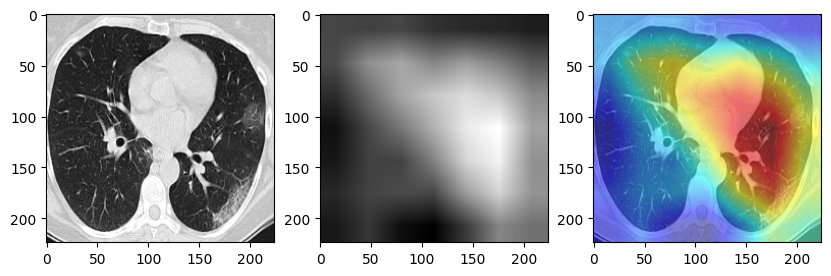

In [40]:
#GradCAM for image_gray4
cam = GradCAM(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray4, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray4, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

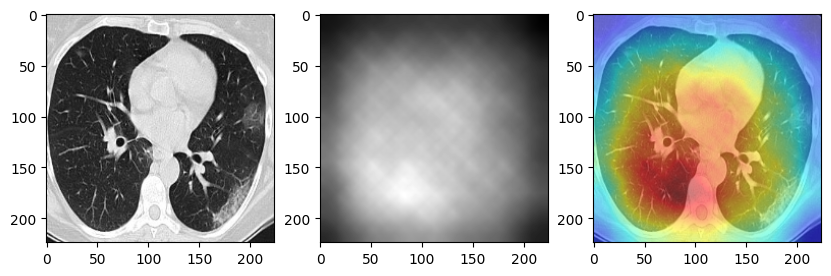

In [41]:
#FullGrad for image_gray4
cam = FullGrad(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray4, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray4, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

(224, 224, 3)


torch.Size([1, 3, 224, 224])

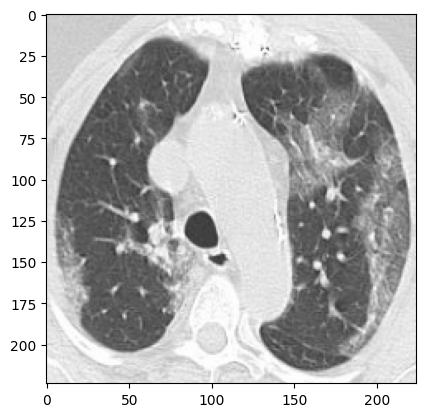

In [42]:
image_gray5=skimage.io.imread("C:/Users/matth/OneDrive/Documentos/UMIAMI (School)/Spring 2023 Semester/CSC546 Machine Learning/hw5s/COVID19CTS224/S224/COVID/Covid (1041).png")
image_gray5=image_gray5.astype("float32")
image_gray5=image_gray5/image_gray5.max()
image_gray5.shape

image_gray5=image_gray5.reshape(224,224,1)
image_color=np.concatenate([image_gray5, image_gray5, image_gray5], axis=2)
print(image_color.shape)
plt.imshow(image_color)

#convert numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

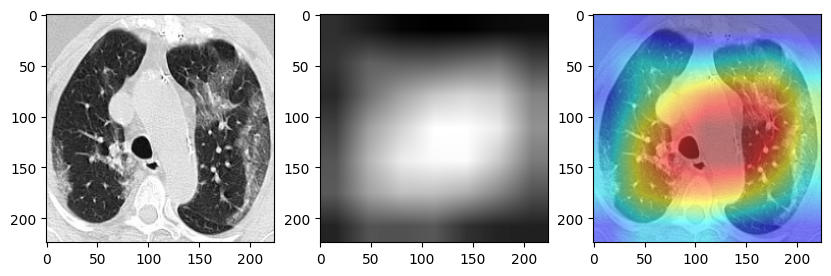

In [43]:
#GradCAM for image_gray5
cam = GradCAM(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray5, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray5, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

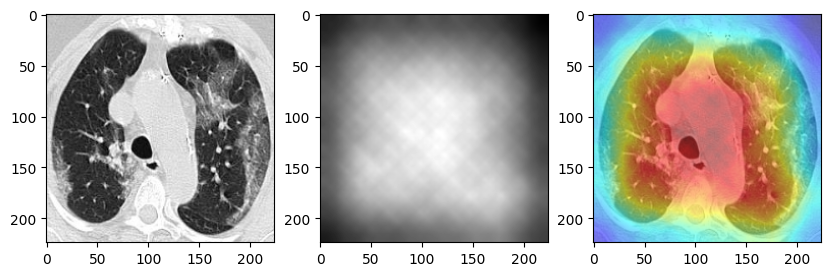

In [45]:
#FullGrad
cam = FullGrad(model=modelS, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input.to(device), targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_gray5, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_gray5, cmap='gray')
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)